In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tqdm import tqdm

### **Load Dataset**

In [ ]:
!git clone https://github.com/allatifatulmuharomiah/Fruit-Ripeness.git

Cloning into 'Fruit-Ripeness'...
remote: Enumerating objects: 14244, done.
remote: Counting objects: 100% (940/940), done.
remote: Compressing objects: 100% (938/938), done.
remote: Total 14244 (delta 3), reused 902 (delta 0), pack-reused 13304
Receiving objects: 100% (14244/14244), 1.53 GiB | 25.52 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (14169/14169), done.


### **Split & Data Augmentation**

In [ ]:
root_dir = '/content/Fruit-Ripeness/Fruit-Ripeness/buah sayur'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
batch_size = 32
train_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 11320 images belonging to 15 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2824 images belonging to 15 classes.


In [ ]:
train_classes = train_generator.class_indices
print("Classes in training set:")
for cls, idx in train_classes.items():
    print(f"Class: {cls}, Index: {idx}")

validation_classes = validation_generator.class_indices
print("\nClasses in validation set:")
for cls, idx in validation_classes.items():
    print(f"Class: {cls}, Index: {idx}")


Classes in training set:
Class: Ripe Apple, Index: 0
Class: Ripe_Banana, Index: 1
Class: Ripe_Bell Pepper, Index: 2
Class: Ripe_Orange, Index: 3
Class: Ripe_Strawberry, Index: 4
Class: Ripe_Tomato, Index: 5
Class: Rotten_Apple, Index: 6
Class: Rotten_Banana, Index: 7
Class: Rotten_Orange, Index: 8
Class: Unripe Apple, Index: 9
Class: Unripe_Banana, Index: 10
Class: Unripe_Bell Pepper, Index: 11
Class: Unripe_Orange, Index: 12
Class: Unripe_Strawberry, Index: 13
Class: Unripe_Tomato, Index: 14

Classes in validation set:
Class: Ripe Apple, Index: 0
Class: Ripe_Banana, Index: 1
Class: Ripe_Bell Pepper, Index: 2
Class: Ripe_Orange, Index: 3
Class: Ripe_Strawberry, Index: 4
Class: Ripe_Tomato, Index: 5
Class: Rotten_Apple, Index: 6
Class: Rotten_Banana, Index: 7
Class: Rotten_Orange, Index: 8
Class: Unripe Apple, Index: 9
Class: Unripe_Banana, Index: 10
Class: Unripe_Bell Pepper, Index: 11
Class: Unripe_Orange, Index: 12
Class: Unripe_Strawberry, Index: 13
Class: Unripe_Tomato, Index: 14


In [ ]:
# Mendapatkan kelas-kelas yang ada dalam dataset
classes = list(train_generator.class_indices.keys())

# Mengatur jumlah gambar yang ingin ditampilkan per kelas
num_images_per_class = 5

# Menampilkan lima gambar per kelas
for cls in classes:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Samples from class: {cls}")

    images_count = 0
    for i, filename in enumerate(train_generator.filenames):
        if filename.split('/')[0] == cls:
            image = plt.imread(train_generator.filepaths[i])
            plt.subplot(1, num_images_per_class, images_count + 1)
            plt.imshow(image)
            plt.axis('off')
            images_count += 1
            if images_count == num_images_per_class:
                break

    plt.tight_layout()
    plt.show()


In [ ]:
# Menampilkan jumlah gambar per kelas di training set
train_class_counts = train_generator.classes
num_images_per_class_train = {class_name: sum(train_class_counts == class_idx) for class_name, class_idx in train_generator.class_indices.items()}
print("Number of images per class in training set:")
print(num_images_per_class_train)

# Menampilkan jumlah gambar per kelas di validation set
val_class_counts = validation_generator.classes
num_images_per_class_val = {class_name: sum(val_class_counts == class_idx) for class_name, class_idx in validation_generator.class_indices.items()}
print("\nNumber of images per class in validation set:")
print(num_images_per_class_val)


Number of images per class in training set:
{'Ripe Apple': 1026, 'Ripe_Banana': 1155, 'Ripe_Bell Pepper': 359, 'Ripe_Orange': 409, 'Ripe_Strawberry': 933, 'Ripe_Tomato': 764, 'Rotten_Apple': 794, 'Rotten_Banana': 1320, 'Rotten_Orange': 720, 'Unripe Apple': 1070, 'Unripe_Banana': 1137, 'Unripe_Bell Pepper': 42, 'Unripe_Orange': 553, 'Unripe_Strawberry': 922, 'Unripe_Tomato': 116}

Number of images per class in validation set:
{'Ripe Apple': 256, 'Ripe_Banana': 288, 'Ripe_Bell Pepper': 89, 'Ripe_Orange': 102, 'Ripe_Strawberry': 233, 'Ripe_Tomato': 191, 'Rotten_Apple': 198, 'Rotten_Banana': 329, 'Rotten_Orange': 180, 'Unripe Apple': 267, 'Unripe_Banana': 284, 'Unripe_Bell Pepper': 10, 'Unripe_Orange': 138, 'Unripe_Strawberry': 230, 'Unripe_Tomato': 29}


### **CNN Model**

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

### **Training**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

Epoch 1/40
353/353 [==============================] - 147s 411ms/step - loss: 1.2291 - accuracy: 0.5445 - val_loss: 0.7672 - val_accuracy: 0.7024
Epoch 2/40
353/353 [==============================] - 145s 411ms/step - loss: 0.7201 - accuracy: 0.7298 - val_loss: 0.6048 - val_accuracy: 0.7710
Epoch 3/40
353/353 [==============================] - 131s 372ms/step - loss: 0.5838 - accuracy: 0.7835 - val_loss: 0.5099 - val_accuracy: 0.8111
Epoch 4/40
353/353 [==============================] - 145s 410ms/step - loss: 0.5192 - accuracy: 0.8094 - val_loss: 0.4170 - val_accuracy: 0.8438
Epoch 5/40
353/353 [==============================] - 145s 410ms/step - loss: 0.4646 - accuracy: 0.8299 - val_loss: 0.3421 - val_accuracy: 0.8700
Epoch 6/40
353/353 [==============================] - 132s 373ms/step - loss: 0.4203 - accuracy: 0.8484 - val_loss: 0.3039 - val_accuracy: 0.8853
Epoch 7/40
353/353 [==============================] - 144s 408ms/step - loss: 0.3732 - accuracy: 0.8599 - val_loss: 0.3057 -

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the saved model in h5 format
food_prediction = '/content/drive/My Drive/food-prediction.h5'


In [ ]:
# Load the saved model
model = tf.keras.models.load_model(food_prediction)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_file = '/content/drive/My Drive/food-prediction.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

In [ ]:
path_to_save = '/content/drive/MyDrive/Fruit Ripeness/my_cnn_model2.h5'


In [ ]:
model = tf.saved_model.load('/content/drive/MyDrive/Fruit Ripeness/my_cnn_model2.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(path_to_save)

In [ ]:
tflite_model_file = '/content/drive/MyDrive/Fruit Ripeness/my_cnn_model2.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

### **Test the Model with TFLite Interpreter**

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
input_details = interpreter.get_input_details()
print("Input shape:", input_details[0]['shape'])

Input shape: [  1 150 150   3]


In [ ]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Mengambil index input tensor
input_index = interpreter.get_input_details()[0]['index']

interpreter.set_tensor(input_index, input_data)
interpreter.invoke()

# Mendapatkan hasil prediksi dari output tensor
output_index = interpreter.get_output_details()[0]['index']
output_data = interpreter.get_tensor(output_index)


In [ ]:
def predict_fruit_ripeness(image_path, model_path='/content/drive/MyDrive/Fruit Ripeness/my_cnn_model2.tflite'):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare input image
    input_shape = input_details[0]['shape']
    input_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(input_shape[1], input_shape[2]))
    input_array = tf.keras.preprocessing.image.img_to_array(input_image)
    input_array = np.expand_dims(input_array, axis=0)
    input_array = input_array.astype('float32') / 255.0

    # Set input tensor and invoke model
    interpreter.set_tensor(input_details[0]['index'], input_array)
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details[0]['index'])

    # Get predicted class index and label
    labels = [
        'Ripe Apple, perkiraan kedaluwarsanya sekitar 1-2 minggu lagi',
        'Ripe Banana, perkiraan kedaluwarsanya sekitar 3-4 hari lagi',
        'Ripe Bell Pepper, perkiraan kedaluwarsanya sekitar 5-7 hari lagi',
        'Ripe Orange, perkiraan kedaluwarsanya sekitar 1-2 minggu lagi',
        'Ripe Strawberry, perkiraan kedaluwarsanya sekitar 1-2 hari lagi',
        'Ripe Tomato, perkiraan kedaluwarsanya sekitar 5-7 hari lagi',
        'Rotten Apple, sudah kedaluwarsa',
        'Rotten Banana, sudah kedaluwarsa',
        'Rotten Orange, sudah kedaluwarsa',
        'Unripe Apple, perkiraan kedaluwarsanya sekitar 2-3 minggu lagi',
        'Unripe Banana, perkiraan kedaluwarsanya sekitar 6-7 hari lagi',
        'Unripe Bell Pepper, perkiraan kedaluwarsanya sekitar 5-7 hari lagi',
        'Unripe Orange,perkiraan kedaluwarsanya sekitar 2-4 minggu lagi',
        'Unripe Strawberry, perkiraan kedaluwarsanya sekitar 3-4 hari lagi',
        'Unripe Tomato, perkiraan kedaluwarsanya sekitar 4-7 hari lagi'
    ]

    # Process prediction
    predicted_class_index = np.argmax(output)
    predicted_label = labels[predicted_class_index]

    # Display image with predicted label
    plt.imshow(input_image)
    plt.axis('off')
    plt.title(predicted_label.split(',')[0])  # Show only the fruit label without expiration info
    plt.show()

    return predicted_label

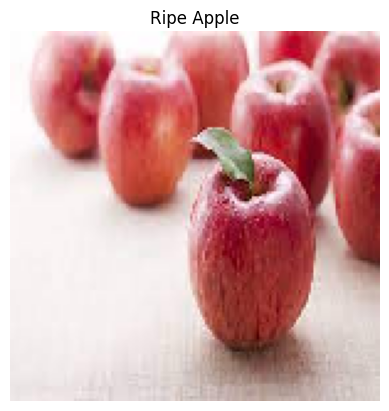

Ripe Apple, perkiraan kedaluwarsanya sekitar 1-2 minggu lagi


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/apelm1.jpeg')
print(fruit_label)

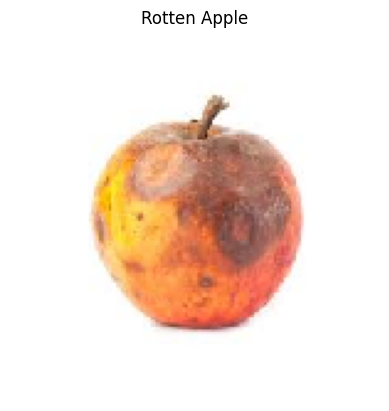

Rotten Apple, sudah kedaluwarsa


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/apelr1.jpeg')
print(fruit_label)

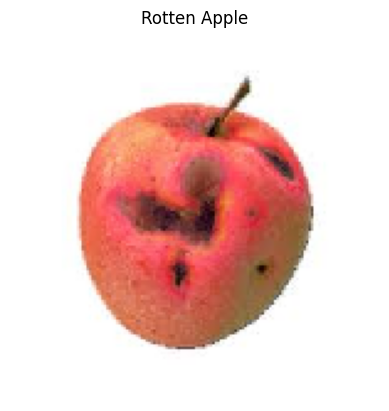

Rotten Apple, sudah kedaluwarsa


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/apelr2.jpeg')
print(fruit_label)

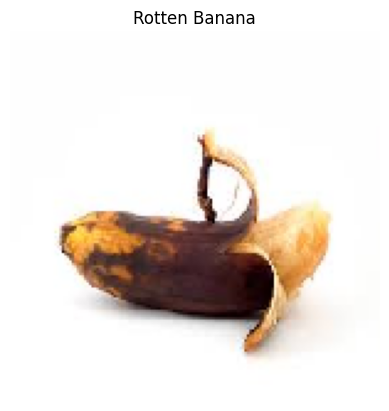

Rotten Banana, sudah kedaluwarsa


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/bananar1.jpeg')
print(fruit_label)

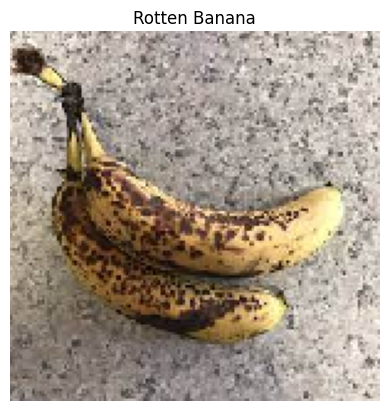

Rotten Banana, sudah kedaluwarsa


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/bananar2.jpeg')
print(fruit_label)

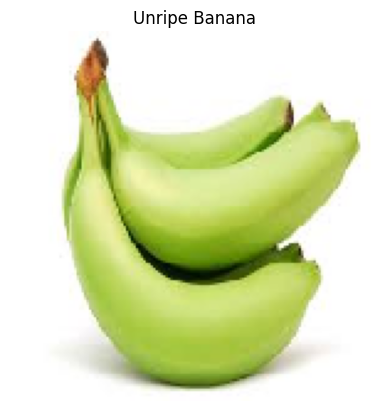

Unripe Banana, perkiraan kedaluwarsanya sekitar 6-7 hari lagi


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/bananaun1.jpeg')
print(fruit_label)

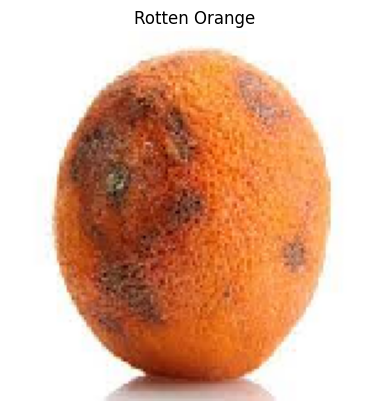

Rotten Orange, sudah kedaluwarsa


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/jeruk31.jpeg')
print(fruit_label)

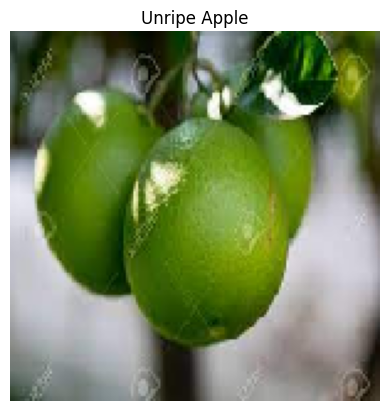

Unripe Apple, perkiraan kedaluwarsanya sekitar 2-3 minggu lagi


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/jerukun2.jpeg')
print(fruit_label)

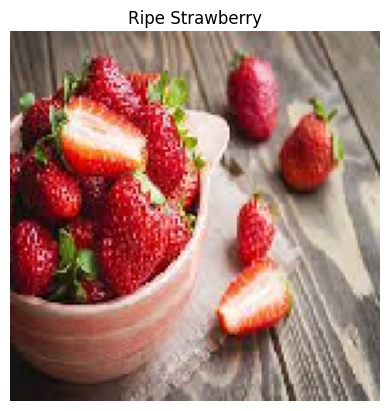

Ripe Strawberry, perkiraan kedaluwarsanya sekitar 1-2 hari lagi


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/stoberim2.jpeg')
print(fruit_label)

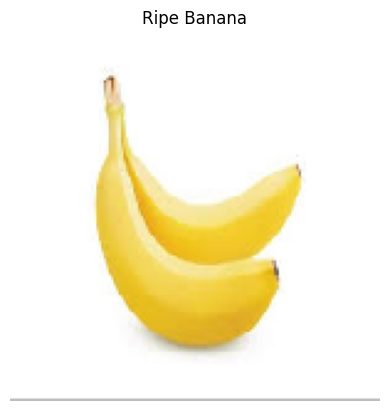

Ripe Banana, perkiraan kedaluwarsanya sekitar 3-4 hari lagi


In [ ]:
fruit_label = predict_fruit_ripeness('/content/drive/MyDrive/Fruit Ripeness/Dataset/tes2/pisangm3.jpeg')
print(fruit_label)